# Spectrum Expension

In [27]:
import yaml

import numpy as np
import matplotlib.pyplot as plt
import torch

from spectrum_expension_utils import *
from inr import SphericalSiren, get_activation

In [28]:
experience = "Spec1"

In [29]:
with open("configs/" + experience + ".yaml", "r") as ymlfile:
    config = yaml.safe_load(ymlfile)

In [30]:
def f(theta, phi):
    mask = phi < np.pi
    
    out = torch.zeros_like(theta)
    out[~mask] = 1.0
    return out

In [31]:
N = 1000
theta, phi = torch.meshgrid(torch.linspace(0, np.pi, N), torch.linspace(0, 2*np.pi, N), indexing='ij')

X_data = torch.stack([theta.flatten(), phi.flatten()], dim=-1)
y_data = f(theta.flatten(), phi.flatten())

In [32]:
network_params = config["NETWORK_PARAMS"]
network_params["activation"] = get_activation(network_params["activation"])

In [33]:
print("Reachable L = K^(Q-1) x L_0 = ", 2**(network_params["Q"]-1) * network_params["L0"])

Reachable L = K^(Q-1) x L_0 =  40


In [34]:
spherical_siren = SphericalSiren(**network_params)      
spherical_siren.load_state_dict(torch.load(config["EXPERIMENT_PARAMS"]["model_path"] + "model.pth", weights_only=True))      

<All keys matched successfully>

In [35]:
losses = torch.load(config["EXPERIMENT_PARAMS"]["results_path"] + "losses.pth", weights_only=False)

losses_train = losses["losses_train"]
losses_val = losses["losses_val"]

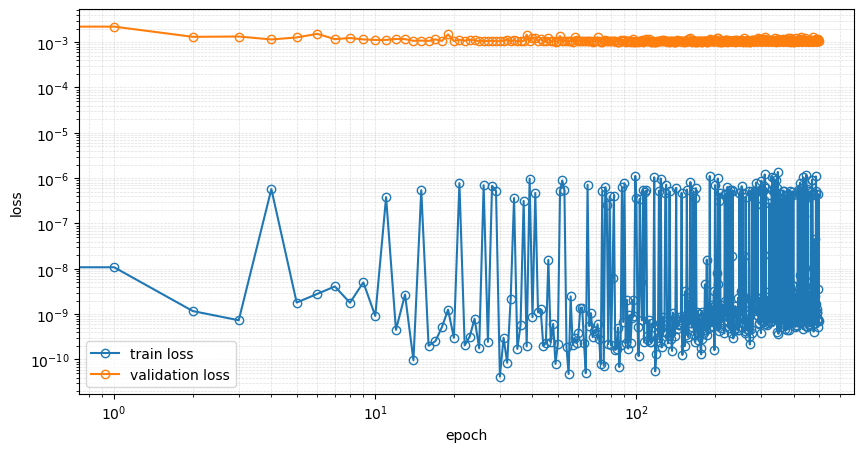

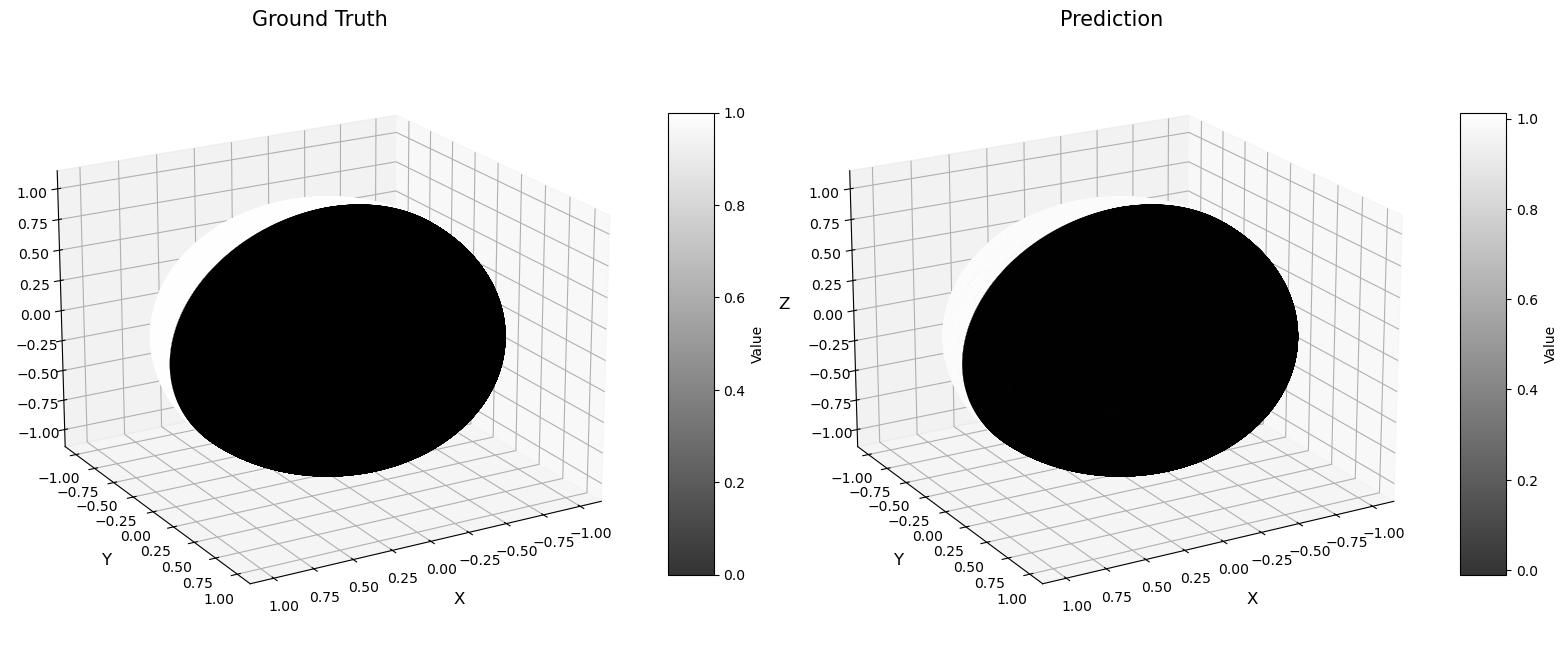

In [36]:
show_learning_curve(losses_train, losses_val, log = True)
show_comparisons(X_data, y_data, spherical_siren(X_data))

In [37]:
coeffs_abs = torch.load(config["EXPERIMENT_PARAMS"]["results_path"] + "spectrum_coeffs.pth", weights_only=False)
coeffs_inside = torch.load(config["EXPERIMENT_PARAMS"]["results_path"] + "spectrum_coeffs_inside.pth", weights_only=False)


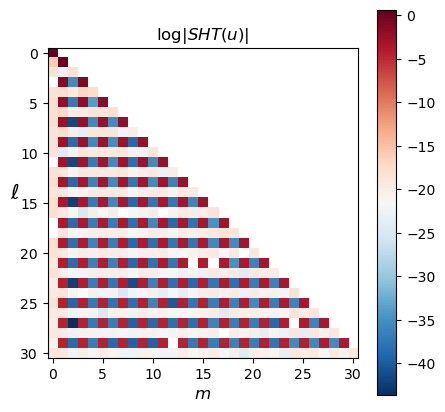

In [44]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(coeffs_abs.log(), cmap="RdBu_r")
plt.xlabel(r"$m$", fontsize = 12)
plt.ylabel(r"$\ell$", rotation= 0 , fontsize = 15)
plt.title("$\log | SHT(u) |$")
plt.colorbar()
plt.show()

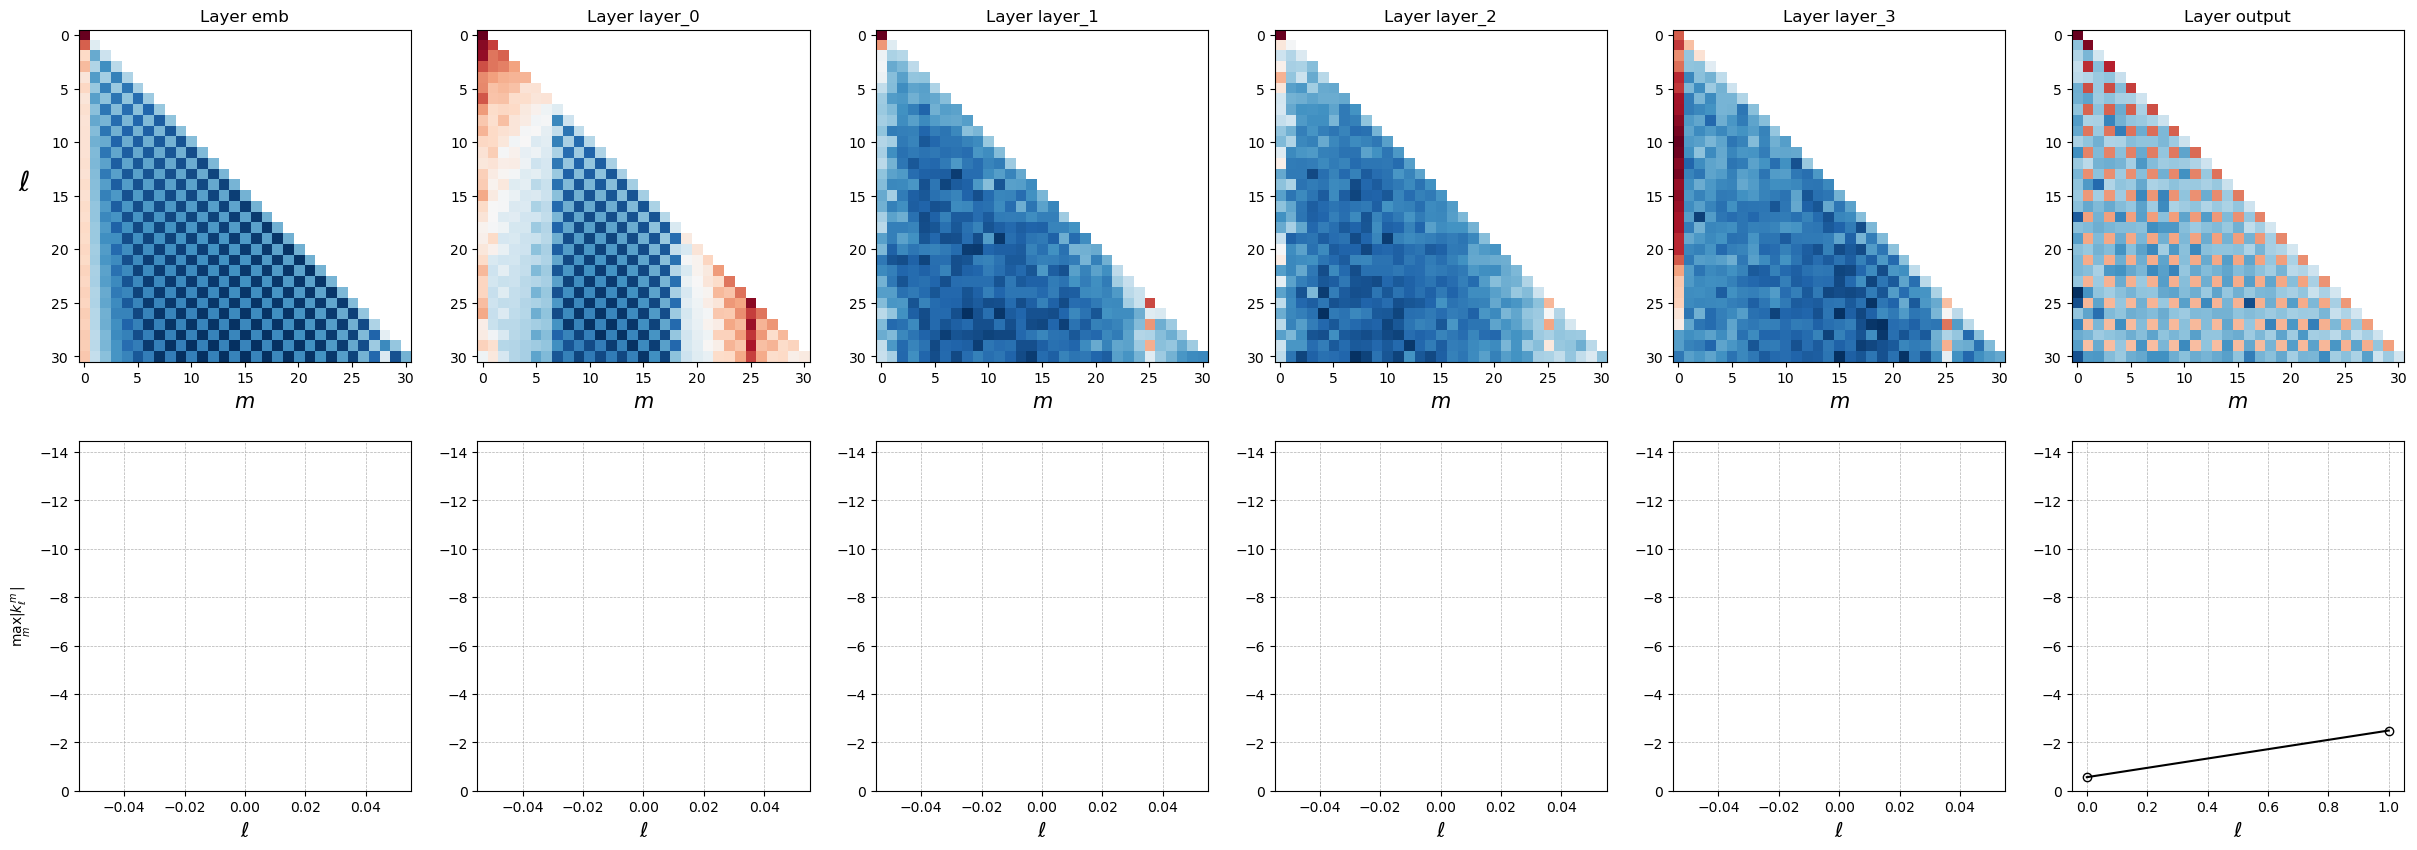

In [ ]:
n_layers = len(coeffs_inside)

fig, axs = plt.subplots(2, n_layers, figsize=(5*n_layers, 10))

y_max_plot = 0

for i, (layer, inside) in enumerate(coeffs_inside.items()):
    axs[0, i].imshow(inside.abs().log(), cmap="RdBu_r")
    axs[0, i].set_title(f"Layer {layer}")
    axs[0, i].set_xlabel(r"$m$", fontsize = 15)
    
    max_coeffs = torch.max(inside.abs(), dim = 0).values.log()
    y_max_plot = max(y_max_plot, max_coeffs.max())  
    axs[1, i].plot(max_coeffs.log(), marker = "o", fillstyle = "none", color = "k", markeredgecolor = "k")
    # axs[1, i].set_title(f"Layer {layer}")
    axs[1, i].set_xlabel(r"$\ell$", fontsize = 15)
    axs[1, i].grid(True, which='both', linestyle='--', linewidth=0.5)


for i in range(n_layers):
    axs[1, i].set_ylim(1e-6, 1.1*y_max_plot)

axs[0, 0].set_ylabel(r"$\ell$", rotation= 0 , fontsize = 20, labelpad = 20)
axs[1, 0].set_ylabel(r"$\max_{m} |k_{\ell}^m|$",fontsize = 10)
plt.show()


